In [1]:
from cluster_model import get_dataset, get_transformer, DATASET_NAME, MODEL_NAME, SEED, N_DATASIZE, get_block_out_label, N_BLOCKS
import cluster_model

ds = get_dataset(DATASET_NAME)
model, _ = get_transformer(MODEL_NAME)
shuffled = ds.shuffle(seed=SEED)['train'][:N_DATASIZE]['text']

ds = shuffled
labs = [get_block_out_label(i) for i in range(N_BLOCKS)]

/home/lev/code/research/ai/lattice_cluster_paths/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
Moving model to device:  cuda


In [2]:
import importlib
importlib.reload(cluster_model)

# TODO: auto sim cutoff needed
decomp = cluster_model.Decomposer(model, ds, labs)
decomp.load()

Creating decomposer with parameter hash a9ba5d753fd502dc8bbf7b6ccce8ebfe0455dfd8
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Getting cluster scores for lattice
Set all initial to 0
Set predictions for layer 0
Set predictions for layer 1
Set predictions for layer 2
Set predictions for layer 3
Set predictions for layer 4
Set predictions for layer 5
Set all probs with predictions
Scoring layer 0
COEFF STUFF 0.0041013304 0.00092185795 (512, 512) -0.7040801 0.952465
Scoring layer 1
COEFF STUFF 0.0038846768 0.00106661 (512, 512) -0.66034037 0.9502581
Scoring layer 2
COEFF STUFF 0.0041926447 0.0012313488 (512, 512) -0.5437158 0.9540029
Scoring layer 3
COEFF STUFF 0.0044522122 0.0013629134 (512, 512) -0.49326012 0.9432759
Scoring layer 4
COEFF STUFF 0.004218388 0.0009841991 (512, 512) -0.545726 0.83370507
CLUSTER SCORES [array([[ 0.6357319 , -0.01282136, -0.05129032, ...,  0.01

In [3]:
decomp.lattice_scores[0].shape

(512, 512)

In [4]:
from typing import List
import utils
importlib.reload(utils)
modified_lattice = decomp.lattice_scores.copy()

# TODO: have function which does something like fixing from the a specific neuron?
# Ie have the sub-lattice with only **related** neurons

def cutoff_lattice(lattice: List[List[List[float]]], related_cutoff = 1):
    print(lattice[0].sum())
    r = [(layer > related_cutoff) * layer for layer in lattice]
    print(r[0].sum())
    return r

def create_sublattice(lattice, layer: int, idx_in_layer: int, related_cutoff = 10):
	with_cutoff = cutoff_lattice(lattice, related_cutoff)

LAST_FEAT = 20
modified_lattice = cutoff_lattice(decomp.lattice_scores, related_cutoff=15)

# utils.top_k_dag_paths_dynamic(modified_lattice, k=10_000)

54.1513
0.0


## Isolate Specific Neurons

In [5]:
import numpy as np

def get_weighting_for_layer(layer: int, n_layers: int, weight_decay=0.95):
    r = np.ones(n_layers)
    r[layer] = 1
    G = weight_decay
    for i in range(layer):
        r[i] = G ** (layer - i)
    for i in range(layer + 1, n_layers):
        # Decrease by Gx per layer
        r[i] = G ** (i - layer)
    return r
    

In [19]:
importlib.reload(utils)
# TODO: restrict lattice, change picture instead of starting elsewhere...
# ~~Use source~~ node
# TODO: ~~SOMEHOW LAYER 2 is where stuff happens~~
cutoff = 0.3
scores_cutoff = [m * m > cutoff for m in modified_lattice]
paths = utils.top_k_dag_paths(decomp.lattice_scores, layer=2, neuron=69, k=20)
paths

(512, 512) (512, 1) (1, 512) (512, 512) 2
([69, 69, 69, 263, 263, 263], 3.9628999866104127)
([69, 69, 69, 69, 69, 69], 3.8435499866104124)
([69, 69, 69, 458, 458, 458], 3.833309986610413)
([69, 69, 69, 478, 478, 478], 3.8131499866104126)
([69, 69, 69, 400, 400, 400], 3.7992399866104125)
([69, 69, 69, 413, 413, 413], 3.7698399866104126)
([478, 478, 69, 263, 263, 263], 3.745939986610413)
([69, 69, 69, 461, 461, 461], 3.7254499866104123)
([69, 69, 69, 179, 179, 179], 3.7172099866104125)
([69, 69, 69, 153, 153, 153], 3.7153799866104125)
([115, 115, 69, 263, 263, 263], 3.7142399866104125)
([69, 69, 69, 271, 271, 271], 3.7125299866104124)
([148, 148, 69, 263, 263, 263], 3.7085099866104128)
([69, 69, 69, 240, 240, 240], 3.7055399866104124)
([69, 69, 69, 401, 401, 401], 3.704039986610413)
([69, 69, 69, 268, 268, 268], 3.696789986610413)
([69, 69, 69, 291, 291, 291], 3.6952399866104124)
([69, 69, 69, 80, 80, 80], 3.6951499866104127)
([69, 69, 69, 11, 11, 11], 3.6908799866104127)
([69, 69, 69, 1

[([69, 69, 69, 263, 263, 263], 3.9628999866104127),
 ([69, 69, 69, 69, 69, 69], 3.8435499866104124),
 ([69, 69, 69, 458, 458, 458], 3.833309986610413),
 ([69, 69, 69, 478, 478, 478], 3.8131499866104126),
 ([69, 69, 69, 400, 400, 400], 3.7992399866104125),
 ([69, 69, 69, 413, 413, 413], 3.7698399866104126),
 ([478, 478, 69, 263, 263, 263], 3.745939986610413),
 ([69, 69, 69, 461, 461, 461], 3.7254499866104123),
 ([69, 69, 69, 179, 179, 179], 3.7172099866104125),
 ([69, 69, 69, 153, 153, 153], 3.7153799866104125),
 ([115, 115, 69, 263, 263, 263], 3.7142399866104125),
 ([69, 69, 69, 271, 271, 271], 3.7125299866104124),
 ([148, 148, 69, 263, 263, 263], 3.7085099866104128),
 ([69, 69, 69, 240, 240, 240], 3.7055399866104124),
 ([69, 69, 69, 401, 401, 401], 3.704039986610413),
 ([69, 69, 69, 268, 268, 268], 3.696789986610413),
 ([69, 69, 69, 291, 291, 291], 3.6952399866104124),
 ([69, 69, 69, 80, 80, 80], 3.6951499866104127),
 ([69, 69, 69, 11, 11, 11], 3.6908799866104127),
 ([69, 69, 69, 145,

## Try different scoring method

In [ ]:
# # TODO: scoring and testing the paths

# importlib.reload(cluster_model)

# # score_path = [69, 2, 493, 289, 511, 48]
# # TODO: embeds to here...
# to_score = ds
# to_score_adj = [s[:300] for s in to_score][:300]
# to_score = to_score_adj
# importlib.reload(cluster_model)
# # TODO: should we work over log everywhere?
# _, top_ds, scores = cluster_model.score_for_neuron(decomp, to_score_adj, LAYER, score_path, top_n=200, weighting_per_layer=get_weighting_for_layer(LAYER, N_BLOCKS))

import math
import numpy as np
from IPython.core.display import display, HTML
from circuitsvis.utils.render import render
# def get_renderable_scores(scored_t: List[str], scores: List


scores_per_token_set = np.array([max(s) for s in scores])
top_args = np.argsort(scores_per_token_set)[::-1]

# scores_per_token_set = [max(s) for s in scores]
# top_args = [s.argmax() for s in scores]

to_score_top = [to_score[i] for i in top_ds]

tokens = [[model.tokenizer.decode(t) for t in model.tokenizer(d)[
    'input_ids']] for d in to_score_top]
tokens_reord = [tokens[i] for i in top_args]
scores_reord = [scores[i] for i in top_args]

# TODO: WHAT IS HAPPENING WITH NAN?
act_simp = [[[[math.exp(10 * tok)]]
             for tok in s] for s in scores_reord]
# TODO sep fun
html = render(
    "TextNeuronActivations",
    tokens=tokens_reord,
    activations=act_simp,
    firstDimensionName="Layer",
    secondDimensionName="Neuron",
    firstDimensionLabels=None,
    secondDimensionLabels=None
)
display(HTML(str(html)))

/home/lev/code/research/ai/lattice_cluster_paths/kmeansmixture_np.py:97: RuntimeWarning: invalid value encountered in divide
  K_mu_x_normed = K_mu_x / np.sum(K_mu_x, axis=-1, keepdims=True)


TOP TOKENS 600 [610, 622, 3044, 3289, 3297, 7241, 7838, 7844, 7849, 7854, 7865, 7873, 7882, 7890, 9144, 11994, 12006, 15719, 17694, 3281, 10256, 4962, 18460, 10734, 7232, 15745, 19139, 5678, 19117, 20197, 17681, 11997, 7161, 21679, 3367, 12014, 7222, 7203, 3306, 7170, 7707, 8913, 3356, 7180, 7189, 1009, 10157, 14331, 22126, 1603, 22103, 22107, 22308, 9744, 16861, 16874, 16545, 6589, 22099, 21047, 2299, 14835, 4402, 10931, 17723, 15215, 6600, 22094, 21356, 4403, 12744, 2317, 7599, 2297, 4020, 6175, 4382, 14909, 21055, 22064, 10560, 16866, 7704, 14893, 21712, 20983, 16858, 8406, 16542, 21129, 6586, 18659, 20778, 15776, 10564, 18922, 1263, 10552, 10563, 16261, 16263, 22068, 13641, 13642, 9287, 16521, 10956, 2279, 22082, 22043, 4021, 2124, 10080, 21102, 17236, 10559, 10568, 10556, 12762, 21710, 22371, 6169, 18639, 18495, 3022, 287, 17688, 21100, 18627, 1854, 21084, 15782, 3913, 15650, 22085, 2185, 10567, 11356, 2180, 20674, 6017, 17357, 5492, 10605, 20281, 1843, 21700, 18641, 8911, 1832, 1

## Try more path like method

In [22]:
"""
Some paths we have seen:
[69, 1, 107, 289, 97, 508] where we have the start
of something after a semicolon, often in code

BUT

[69, 2, 493, 289, 511, 48] is different!
Here it is the space after a period with words like "It" "Here" "The" or a new line


"""

# TODO: SIOMETHING WRONG HERE WITH THE PATHS
import numpy as np
import metric
importlib.reload(cluster_model)
importlib.reload(utils)
importlib.reload(metric)
score_path = [69, 69, 69, 263, 263, 263]
LAYER = 2
# score_path = [0, 0, 69, 51, 195, 99]
# score_path = [69, 1, 107, 289, 97, 508]

"""
Paths which seem to have meaning:

"""

weighting_per_layer = get_weighting_for_layer(LAYER, N_BLOCKS, weight_decay=0.92)
# weighting_per_layer[0] = 0
# weighting_per_layer[1] = 0
print(weighting_per_layer)
to_score = [d[:300] for d in ds][:200]
scores = decomp.score(
    to_score,
    score_path=score_path,
    # TODO: how do we weight???
    weighting_per_layer=weighting_per_layer
)

scores_per_token_set = np.array([max(s) for s in scores])
top_args = np.argsort(scores_per_token_set)[::-1]

# TODO: we have the weights here

tokens = [[model.tokenizer.decode(t) for t in model.tokenizer(d)[
    'input_ids']] for d in to_score]
tokens_reord = [tokens[i] for i in top_args]
scores_reord = [scores[i] for i in top_args]

NameError: name 'metric' is not defined

In [ ]:
import math
from IPython.core.display import display, HTML
import math
import numpy as np

# TODO: WHAT IS HAPPENING WITH NAN?
# act_simp = [[[[(math.exp(tok * 10))]]
#              for tok in s] for s in scores_reord]
act_simp = [[[[((tok * 10))]]
             for tok in s] for s in scores_reord]
# TODO sep fun
html = render(
    "TextNeuronActivations",
    tokens=tokens_reord,
    activations=act_simp,
    firstDimensionName="Layer",
    secondDimensionName="Neuron",
    firstDimensionLabels=None,
    secondDimensionLabels=None
)
display(HTML(str(html)))

/tmp/ipykernel_113163/2005295957.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Look at distributions of scores

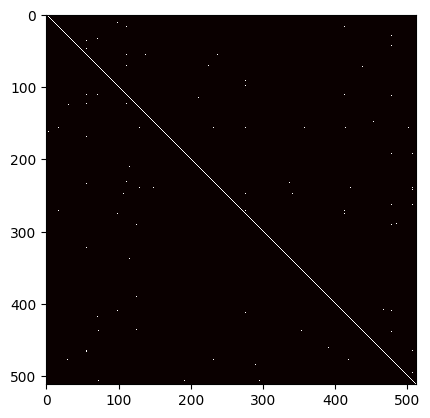

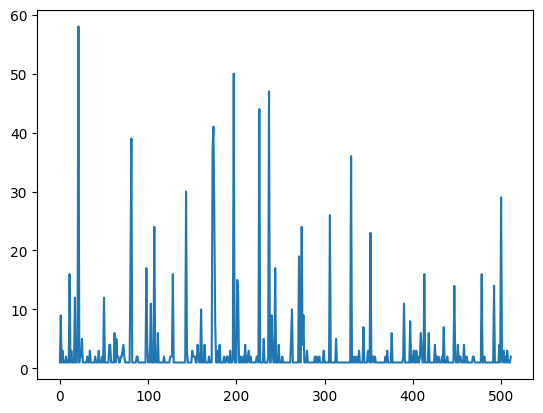

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get distribution of lattice scores

LAYER_START = 1
cutoff = 0.2

# ax = sns.heatmap(decomp.lattice_scores[LAYER_START])
plt.imshow((decomp.lattice_scores[LAYER_START] > cutoff), cmap='hot', interpolation='nearest')
plt.show()

plt.plot((decomp.lattice_scores[3] > cutoff).sum(axis=1))